## Objective 
Q1 - Is vine reviews worth the investment - i.e., do vine reviewers share the same sentiment as the regular users ? 
Q2 - weed out bad vine reviewers.
Q2 - trends in books
Q3 - Recommender

In [9]:
import pandas as pd
import numpy as np
import random


import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,HashingVectorizer

from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans, MiniBatchKMeans#, SpectralClustering, MeanShift, AgglomerativeClustering
from sklearn import metrics

from textblob import TextBlob
from yellowbrick.text import TSNEVisualizer
from yellowbrick.cluster import InterclusterDistance
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

## Data Importing with Random Sampling

In [214]:
filename = 'data/processed/books.csv'
n = sum(1 for line in open(filename))-1  # Calculate number of rows in file
s = n//100  # sample size of 10%
skip = sorted(random.sample(range(1, n+1), n-s))  # n+1 to compensate for header 
df = pd.read_csv(filename, skiprows=skip)

In [215]:
df.shape

(103190, 15)

In [216]:
def chunk_preprocessing(df, cols):
    df = df[cols]
    return df

In [217]:
cols = ['review_id', 'review_date', 'review_body', 'product_parent', 'vine','verified_purchase', 'star_rating', 'customer_id', 'product_id']
df = chunk_preprocessing(df, cols).set_index('review_id')
df = df[df.review_date != ''] # eliminating the reviews without a date.
display(df.shape)
df.head()

(103190, 8)

,review_date,review_body,product_parent,vine,verified_purchase,star_rating,customer_id,product_id
review_id,,,,,,,,
RH3T5W9SIVZ3G,2015-08-31,As expected,642407727,N,Y,5,12074981,0755357175
R2FCSF5Z175260,2015-08-31,Book may be OK if you are not familiar with Wi...,700964473,N,Y,3,52810258,1515195031
R38D56Z3M36EYX,2015-08-31,Great quality! I like the fact that it is smal...,783156692,N,Y,5,22831157,1935414283
R2QS0NMHQKUX3A,2015-08-31,A lot of really good thought provoking materia...,974718250,N,Y,5,11058958,1885228678
R2JS8M4VRHX2M2,2015-08-31,This book combines a novel approach top-notch...,372776861,N,N,5,49441264,1118422147


## EDA

In [218]:
df.product_parent.nunique()

81414

In [219]:
def plot_dist (df, title='Distribution of ratings'):
    fig, ax = plt.subplots()
    plt.title(title, fontsize=15)
    sns.countplot(df.star_rating)
    ax.set_ylabel('No. of Ratings(Millions)')
    plt.show()

In [220]:
def date_filter(df, start, end):
    mask = (df.timestamp > pd.to_datetime(start)) & (df.timestamp < pd.to_datetime(end))
    df = df[mask]
    return df

In [221]:
### Filtering_into_subgroups
def vine_reviewers_rating_filter(df, max_rate=5, min_rate=4, vine='Y'):
    df = df[df.vine == vine]
    df = df[(df.star_rating >= min_rate) & (df.star_rating <= max_rate)]
    return df

1. Are vine users a good representation of the regular user

A. compare 4-5star rated topics between regular user and vine user

B. compare 1-3 star rated topics between regular user and vine user

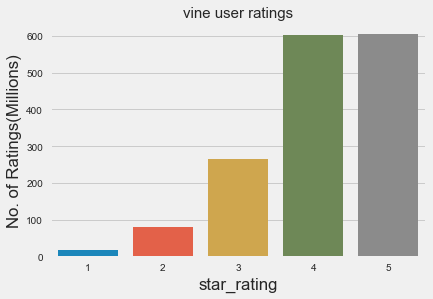

(1570, 8)

In [222]:
all_vine_user = vine_reviewers_rating_filter(df, max_rate=5, min_rate=1, vine='Y')
plot_dist(all_vine_user, title='vine user ratings')
all_vine_user.shape

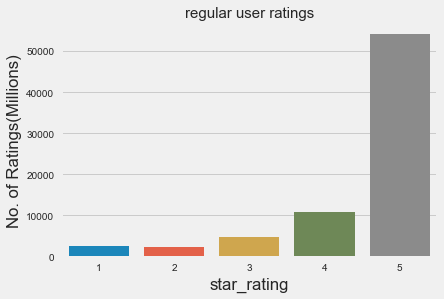

(74302,)

In [224]:
all_regular_user = vine_reviewers_rating_filter(df, max_rate=5, min_rate=1, vine='N')
all_regular_user = all_regular_user[all_regular_user.verified_purchase=='Y']
plot_dist(all_regular_user, title='regular user ratings')
all_regular_user.star_rating.shape

In [29]:
regular_user_low_rate = vine_reviewers_rating_filter(all_regular_user, max_rate=4, min_rate=1, vine='N')
display(regular_user_low_rate.shape)

(20481, 8)

In [24]:
regular_user_high_rate = vine_reviewers_rating_filter(all_regular_user, max_rate=5, min_rate=5, vine='N')
regular_user_high_rate.shape

(53993, 8)

In [25]:
vine_user_low_rate = vine_reviewers_rating_filter(all_vine_user, max_rate=4, min_rate=1, vine='Y')
vine_user_low_rate.shape

(895, 8)

In [26]:
vine_user_high_rate = vine_reviewers_rating_filter(all_vine_user, max_rate=5, min_rate=5, vine='Y')
vine_user_high_rate.shape

(598, 8)

In [27]:
all_vine_user.customer_id.nunique()

979

2. weed out the reviewer with a taste that doesnt match with the majority
vine user group by user - for each user 
identify 4-5 star rated topics and 1-3 star rated topics.

In [30]:
vine_user_count = all_vine_user.groupby(['customer_id'])['review_body'].count().reset_index(name='count')
vine_user_count = vine_user_count.sort_values('count', ascending=False)
vine_user_count = vine_user_count[vine_user_count['count']>=0]
#display(vine_user_count)
vine_user_id = list(vine_user_count['customer_id'].values)
display('Total number of vine reviewers', len(vine_user_id))
freq_vine_user_count = vine_user_count[vine_user_count['count']>=5]
display(freq_vine_user_count)
freq_vine_user_id = list(freq_vine_user_count['customer_id'].values)
display('Total number of frequent vine reviewers', len(freq_vine_user_id))


'Total number of vine reviewers'

979

,customer_id,count
485,46877221,27
394,40661621,15
257,33376665,15
753,51925793,13
422,42800127,12
585,49857171,8
227,30628369,7
32,13171749,7
174,25388755,6
665,51002365,6


'Total number of frequent vine reviewers'

33

In [33]:
freq_vine_users_df = all_vine_user[all_vine_user.customer_id.isin(vine_user_id)]

freq_vine_users_df_grouped = freq_vine_users_df.groupby(['customer_id'])['review_body'].count().reset_index(name='count')
freq_vine_users_df_grouped = freq_vine_users_df_grouped.sort_values('count', ascending=False)
freq_vine_users_df_grouped = freq_vine_users_df_grouped[freq_vine_users_df_grouped['count']>=5]
len(freq_vine_users_df_grouped)


33

In [37]:
freq_vine_user_hr = freq_vine_users_df[freq_vine_users_df.star_rating>4]
freq_vine_user_hr_grouped = pd.DataFrame(freq_vine_user_hr.groupby(\
                    ['customer_id', 'star_rating','review_body'])\
                    ['star_rating'].count())
freq_vine_user_hr_grouped = freq_vine_user_hr_grouped.drop(columns=['star_rating'])

freq_vine_user_hr_grouped.head()

,,
customer_id,star_rating,review_body
10982778,5,Merlin has to take Arthur on the run with trusted friends. It’s not just Vortigern but others that are after both Merlin and Arthur. Merlin is constantly fighting different people trying to keep everyone safe. But as he is fighting them he is fighting himself. He found God when he was blind and trusted prayer. Since he has reclaimed his vision it seems that he has strayed from God. That the further he gets from God the harder things seem to be getting.<br /><br />I really felt for Merlin’s half sister Ganieda. Although she is young and has power it seems everyone trying to control her. She tries to fight them off as long as she can but falls under her grandfather’s care. She also develops a deep hatred for Merlin and is going to kill him one way or another.<br /><br />This is the first book in the series that I have read. I admit that I was a little lost in the beginning with all the characters that are in it but it was easy to get into the story. I don’t know a lot of the Arthurian mythology but this book has me craving the original story.<br /><br />I liked how the story is both a fantasy but also religious without being too preachy. Following Merlin I can see how important God is to him but I can also see him struggling with following his word while trying to do the right thing. Just like in real life releasing that death grip you have on a situation is hard but at time that is what you have to do and trust in God.<br /><br />I really liked this book. It’s a great epic fantasy. Now I’m going to have to go back and read the first book Merlin’s Blade to catch up.<br /><br />Shawn Kovacich<br />Author and Creator of numerous books and DVD's.
11092014,5,I found The Most to Lose to be a very enjoyable historical romance. The author knows her craft. Like most historical romance novels the plot is not too deep and the outcome is somewhat predictable.<br /><br />However I think the quality of this book is a notch above most I've read in the genre--especially recent books. The characters are well developed and fully engaged. Minor characters do not clutter up the story and the plot moves along nicely with no draggy spots and no gaps.<br /><br />The seamless flow of events and the author's skill at storytelling made this book (for me) very entertaining. I look forward to finding more books by this author.
11169499,5,Pirate Hunters is an excellent read of a little known shipwreck and pirate that most people hadnt heard of. The reporting told through this book of following two divers who were interested in finding their own major discovery on their own along with one man they worked with for the rights to the area was quite interesting. Mr. Kurson's storytelling made it go beyond a simply regurgitation of facts to an an actual full blown provocative and enthralling narrative of their quest. The insights into the key characters lives the day to day struggles of their group and disagreements the trips to fact search and lastly the rush to be the first ones to find this made it a blast.<br /><br />Though it is on pirates a topic that so may feel they know everything about it I think it was fresh enough and unique enough to be read by enthusiasts. A TV or Hollywood knowledge of pirates is not what this covers and it goes way beyond it into many of the details regarding how pirates in the Jamaica and other area were. It doesnt get too detailed however as there are other books the writer references for that but it provides enough details to make this book a great tool to learn more about them.<br /><br />Epilogue was great though I was sad at one of the outcomes I hope we do get another story some day detailing their next find.
11301320,5,Liar’s Bench<br />Written by Kim Michele Richardson<br />The year is 1972 and the town Peckinpaw Kentucky. Peckinpaw is a small town filled with bitterness hatred and racism. There is an old oak bench in the town’s square; it was made from the gallows of Fra

In [39]:
vine_user_lr = freq_vine_users_df[freq_vine_users_df.star_rating<5]
vine_user_lr_grouped = pd.DataFrame(vine_user_lr.groupby(['customer_id', 'star_rating','review_body'])\
                    ['star_rating'].count()).drop(columns=['star_rating'])


vine_user_lr_grouped.head()


Empty DataFrame
Columns: []
Index: [(10768428, 4, It is with vivid prose that Bruce Machart provides the reader with a tale of Texas during the turn of the 20th century.  A woman dies in childbirth leaving her four sons without a mother and a father who is emotionally distraught by her death.  The father seems never to have gotten over his wife's death.  He appears to be a rather brutal man who ultimately causes both emotional and physical harm to all of his sons.<br /><br /> The last-born son  Karel  proves to be adept at horseback riding.  His father wages his son's talents as a horseman in an acreage-staked horserace.  Fortunes are at risk in this wager against a Spanish patriarch who has beautiful daughters.<br /><br />There are parts of this book that are beautifully rendered.  It is an epic tale and evokes a period in our country's landscape.), (10982778, 3, This story starts out with Dani Lancing being murdered and the killer never found. Twenty years later  her father is divorced and consoles himself with his daughter’s ghost. Her mother is still looking into her cold case file to find out who the killer was. Tom  her former boyfriend  is a police officer that helps with such cases as Dani’s with the goal of eventually finding the killer. The only problem is there are so many dark secrets that keep messing up a simple investigation.<br /><br />This is a mess of a story and not what I expected when I got this book. The one thing I liked about it was how the family and boyfriend drifted after the killing of Dani. I felt this was a realistic portrayal. From there  I had a hard time getting into this book. From the start I couldn’t follow right away and couldn’t even figure out when the time period was.<br /><br />The next thing was that I really could not relate to the characters. They were all horrible in their own way. I started feeling bad for Dani but ended up not liking her too. The ending was a let down too.<br /><br />Now  having said that  I do think that many people will like this book. There is a pretty good mystery going through the story. I do recommend getting this book; it may be the one that is your new favorite.<br /><br />Shawn Kovacich<br />Author and Creator of numerous books and DVD's.), (10982778, 4, Bruno’s father has just moved to take charge of a new parish. Bruno and his brother Sylvio go to Suburban High School. But strange things happen when the kids turn 16  they gain supernatural powers. Those that use the powers for good are Kind and those that use them for evil are Unkind. Bruno is accepted into the Rosary group  which is down to three member since the others graduated.<br /><br />Bruno received different challenges that help increase different areas of his powers. But this is not the only thing going on at school. There is a kiss curse  where a person receives a note on a place and time to meet and they are cursed by the betrayal of a kiss to one they love. There is also a ghost and depression and the regular dramas of high school.<br /><br />I admit that I have not read the first book in this series. I do like Pull Down the Night and think it could be used as a standalone story. I liked the idea of this story  great concept and characters. I liked the idea of a new kid and developing supernatural powers but having a mystery at the same time. It was also interesting the different music and artists and such. There were several times that I was searching information on the internet to figure out what they were talking about.<br /><br />One of the drawbacks I had was the whole straight gay issue. Don’t get me wrong  I’m not complaining. But what got me was how accepting everyone was about it. It was just unrealistic to me. It also got me how if a guy was down another would just hug him and things would be okay. It is a touch unrealistic and was a sticking point for me.<br /><br />Beyond that  this is a good story. I am going to be getting the first book to see what happened and will probably b

In [42]:
most_reviewed_vine_cus = freq_vine_users_df[freq_vine_users_df.customer_id==46877221]
len(most_reviewed_vine_cus)
most_reviewed_vine_cus.iloc[0,:]

review_date                                                 2015-07-03
review_body          This is a book that had me in its spell for a ...
product_parent                                               782875336
vine                                                                 Y
verified_purchase                                                    N
star_rating                                                          4
customer_id                                                   46877221
product_id                                                  0553394819
Name: R3M3WI5Q2VFDQX, dtype: object

## Text Preprocessing

1. change product_title to review body
2. date separations monthwise

Plan
3. separate vine vs non-vine topics
4. text preprocessing - with spacy / nltk.

In [43]:
regular_users_lr_corpus = pd.DataFrame(regular_user_low_rate, columns=['review_body', 'star_rating'])
regular_users_lr_corpus = regular_users_lr_corpus.dropna().reset_index(drop=True)
display(len(regular_users_lr_corpus))
regular_users_lr_corpus.head()

20481

,review_body,star_rating
0,wish the shopping list sections was longer on ...,4
1,A good book a bit too much focus on financial...,3
2,I was not happy as I wanted a book on the Hist...,2
3,Most of this book he just pats himself on the ...,3
4,A chase comes to an end and so does this seri...,4


In [44]:
regular_users_hr_corpus = pd.DataFrame(regular_user_high_rate, columns=['review_body', 'star_rating'])
regular_users_hr_corpus = regular_users_hr_corpus.dropna().reset_index(drop=True)
display(len(regular_users_hr_corpus))
regular_users_hr_corpus.head()

53993

,review_body,star_rating
0,We love Arnold Lobel's books. Often buy this s...,5
1,GREAT THANKS.,5
2,excellent,5
3,This is still one of my favorite non-fiction b...,5
4,Beautiful,5


In [45]:
vine_users_lr_corpus = pd.DataFrame(vine_user_low_rate, columns=['review_body', 'star_rating'])
vine_users_lr_corpus = vine_users_lr_corpus.dropna().reset_index(drop=True)
display(len(vine_users_lr_corpus))
vine_users_lr_corpus.head()

895

,review_body,star_rating
0,My kid read this series a couple of years ago....,4
1,The Heart Healers by James Forrester is the ...,4
2,Lauren Redniss' new illustrated book is a scat...,4
3,Not a primer for leaping without a net but mo...,3
4,My son just started AP World History so I thou...,4


In [46]:
vine_users_hr_corpus = pd.DataFrame(vine_user_high_rate, columns=['review_body', 'star_rating'])
vine_users_hr_corpus = vine_users_hr_corpus.dropna().reset_index(drop=True)
display(len(vine_users_hr_corpus))
vine_users_hr_corpus.head()

598

,review_body,star_rating
0,The story opens with the vivid thoughts of Odi...,5
1,Katherine has been told that she has only mont...,5
2,Often times cookbooks tied to a business are s...,5
3,A really terrific read. Maybe not quite a 5 s...,5
4,Book 104 Read in 2015<br />The Revolution of ...,5


### Test Cleaning

In [47]:
import regex as re
def text_cleaning(corpus):
    return re.sub(r'[^\w]\n', ' ', corpus)

In [48]:
for i in range(len(vine_users_hr_corpus)):
    vine_users_hr_corpus.loc[i,'review_body'] = text_cleaning(vine_users_hr_corpus.loc[i,'review_body'])

In [49]:
for i in range(len(vine_users_lr_corpus)):
    vine_users_lr_corpus.loc[i,'review_body'] = text_cleaning(vine_users_lr_corpus.loc[i,'review_body'])

In [50]:
for i in range(len(regular_users_hr_corpus)):
    regular_users_hr_corpus.loc[i,'review_body'] = text_cleaning(regular_users_hr_corpus.loc[i,'review_body'])

In [51]:
for i in range(len(regular_users_lr_corpus)):
    regular_users_lr_corpus.loc[i,'review_body'] = text_cleaning(regular_users_lr_corpus.loc[i,'review_body'])

### Adding Stop Words

In [254]:
stop_words = stopwords.words('english')

In [255]:
sw_list1 = ['fascinating', 'enthralling', 'engrossing', 'nice', 
                        'people','youre', 'wa', 'book', 'good', 'buy', 'bought', 
                        'ok', 'better', 'best', 'help', 'little', 'br',
                        'br br', 'author', 'book br', 'ha', 'expected', 'wasn',
                        'okay', 'quite', 'story', 'really', 'didn', 'little',
                        'information', 'disappointed', 'read', 'interesting', 
                        'read book', 'hard', 'easy', 'page', 'cover', 'small',
                        'missing', 'quality', 'helpful', 'feel', 'description', 
                        'great', 'good', 'better', 'best','enjoy', 'boring', 
                        'poorly', 'he', 'awesome', 'bad', 'actually', 'words', 
                        'pages', 'thought', 'would', 'thing', 'well', 'written', 'read',
                        'reading', 'thinking', 'get', 'could', 'many', 'lot', 'amazing',
                        'also', 'books', 'perfect', 'way', 'make', 'us', 'highly', 'copy', 
                        'full', 'must', 'anyone', 'like', 'long', 'high', 'fast', 'wanted',
                        'text', 'came', 'use', 'liked', 'wonderful', 'excellent', 'wait', 
                       'beautiful', 'see', 'thank', 'thanks', 'thanked', 'needed', 'got',
                       'every', 'even', 'much', 'know', 'gave', 'give', 'say', 'tell']
stop_words.extend(sw_list1)

#### POS - Adj / Adv removal

In [257]:
from spacy import displacy
from itertools import chain
import itertools

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def add_stop_words(doc):
    new_stop_words_ = []
    for t in doc:
            if (t.pos_ == 'ADJ') or (t.pos_ == 'ADV'):
                new_stop_words_.append(t)
    return list(set(new_stop_words_))

sw_list2 = []
for doc in nlp.pipe(all_regular_user.review_body):
    sw_list2 = itertools.chain(sw_list2, add_stop_words(doc))

TypeError: Argument 'string' has incorrect type (expected str, got float)

In [ ]:
for i in sw_list2:
    stop_words.append(i)

stop_words = list(set(stop_words))
len(stop_words)

In [58]:
stopwords_df = pd.DataFrame(stop_words, columns=["stop_words"])
stopwords_df.to_csv('stop_words.csv', index=False)

#### bigrams

In [59]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [1424]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [1425]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    trigram = gensim.models.Phrases(bigram[words], min_count = tri_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return bigram_mod, trigram_mod

In [1426]:
for doc in nlp.pipe(regular_users_corpus.review_body):
    words = list(sent_to_words(doc))

KeyboardInterrupt: 

In [ ]:
words

In [1070]:
bigram_tr, trigram_tr = bigrams(words)

In [1071]:
bigram_tr

In [64]:
cv = CountVectorizer(stop_words=stop_words, min_df=0.01, max_df=0.1)
doc_word = cv.fit_transform(all_regular_user.review_body)
cv_corpus = pd.DataFrame(doc_word.toarray(), columns=cv.get_feature_names(), index=all_regular_user.index)
cv_corpus.head()


,able,absolutely,age,ago,almost,along,already,although,always,amazon,...,works,world,worth,write,writer,writing,year,years,yet,young
review_id,,,,,,,,,,,,,,,,,,,,,
R1V4BWEJJQLAOW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R3EMQQ1GPVT8WL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1L0NE9TE6EAYU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R2YBS05VBA9E8R,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1BMP1K70HKX8,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Testing Spacy
#### Spacy to get parts of speech (pos_) and dependency (dep_)


#### Spacy nlp.pipe to process documents

In [1073]:
# %%time
# from spacy import displacy
# nlp = spacy.load('en_core_web_sm')

# def text_preprocess(text):
#     doc = nlp(text)
#     for t in doc:
#         if t.lower_ in ['awesome', 'super', 'excellent']:
#             if t.pos_ != 'NOUN' :
#                 if t.dep_ != 'amod':
#                     return True
#     return False

# #generator
# new_corpora = (i for i in corpus if text_preprocess(i))
# [next(new_corpora) for i in range (3)]

In [1074]:
# sentence = "The book was super interesting."
# displacy.render(nlp(sentence))
# #spacy.explain("acomp")

### Lemmatize and Stemming

In [65]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
snowball_stem = SnowballStemmer('english')
lancaster_stem = LancasterStemmer('english')

from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [67]:
def snowball(text):
    return ' '.join([snowball_stem.stem(word) for word in text.split(' ')])

def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])

Initial trial on 50% of data showed that lemmatization worked best, compared to stemming. So Lemmatization was used for all subsequent tests

In [4]:
#regular_users_corpus['snowball'] = regular_users_corpus.review_body.apply(snowball)

In [68]:
regular_users_hr_corpus['lemmatized'] = regular_users_hr_corpus.review_body.apply(lemmatize)

In [69]:
regular_users_lr_corpus['lemmatized'] = regular_users_lr_corpus.review_body.apply(lemmatize)

In [70]:
vine_users_hr_corpus['lemmatized'] = vine_users_hr_corpus.review_body.apply(lemmatize)

In [71]:
vine_users_lr_corpus['lemmatized'] = vine_users_lr_corpus.review_body.apply(lemmatize)

### Countvectorizer and TFIDF

In [258]:
regular_hr_tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
regular_hr_tfidf_doc_word = regular_hr_tfidf.fit_transform(regular_users_hr_corpus.lemmatized)

regular_hr_dtm_tfidf = pd.DataFrame(regular_hr_tfidf_doc_word.toarray(), columns=regular_hr_tfidf.get_feature_names(), index=regular_users_hr_corpus.lemmatized.index)
regular_hr_dtm_tfidf.shape

(53993, 241)

In [259]:
regular_lr_tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
regular_lr_tfidf_doc_word = regular_lr_tfidf.fit_transform(regular_users_lr_corpus.lemmatized)

regular_lr_dtm_tfidf = pd.DataFrame(regular_lr_tfidf_doc_word.toarray(), columns=regular_lr_tfidf.get_feature_names(), index=regular_users_lr_corpus.lemmatized.index)
regular_lr_dtm_tfidf.shape

(20481, 365)

In [260]:
vine_hr_tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
vine_hr_tfidf_doc_word = vine_hr_tfidf.fit_transform(vine_users_hr_corpus.lemmatized)

vine_hr_dtm_tfidf = pd.DataFrame(vine_hr_tfidf_doc_word.toarray(), columns=vine_hr_tfidf.get_feature_names(), index=vine_users_hr_corpus.lemmatized.index)
vine_hr_dtm_tfidf.shape

(598, 1726)

In [261]:
vine_lr_tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
vine_lr_tfidf_doc_word = vine_lr_tfidf.fit_transform(vine_users_lr_corpus.lemmatized)

vine_lr_dtm_tfidf = pd.DataFrame(vine_lr_tfidf_doc_word.toarray(), columns=vine_lr_tfidf.get_feature_names(), index=vine_users_lr_corpus.lemmatized.index)
vine_lr_dtm_tfidf.shape

(895, 1574)

In [262]:
regular_hr_cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
regular_hr_cv_doc_word = regular_hr_cv.fit_transform(regular_users_hr_corpus.lemmatized)

regular_hr_dtm_cv = pd.DataFrame(regular_hr_cv_doc_word.toarray(), columns=regular_hr_cv.get_feature_names(), index=regular_users_hr_corpus.lemmatized.index)
regular_hr_dtm_cv.shape

(53993, 241)

In [263]:
regular_lr_cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
regular_lr_cv_doc_word = regular_lr_cv.fit_transform(regular_users_lr_corpus.lemmatized)

regular_lr_dtm_cv = pd.DataFrame(regular_lr_cv_doc_word.toarray(), columns=regular_lr_cv.get_feature_names(), index=regular_users_lr_corpus.lemmatized.index)
regular_lr_dtm_cv.shape

(20481, 365)

In [264]:
vine_lr_cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
vine_lr_cv_doc_word = vine_lr_cv.fit_transform(vine_users_lr_corpus.lemmatized)

vine_lr_dtm_cv = pd.DataFrame(vine_lr_cv_doc_word.toarray(), columns=vine_lr_cv.get_feature_names(), index=vine_users_lr_corpus.lemmatized.index)
vine_lr_dtm_cv.shape

(895, 1574)

In [265]:
vine_hr_cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
vine_hr_cv_doc_word = vine_hr_cv.fit_transform(vine_users_hr_corpus.lemmatized)

vine_hr_dtm_cv = pd.DataFrame(vine_hr_cv_doc_word.toarray(), columns=vine_hr_cv.get_feature_names(), index=vine_users_hr_corpus.lemmatized.index)
vine_hr_dtm_cv.shape

(598, 1726)

## Clustering

In [73]:
def find_optimal_clusters(data,min_k=2, max_k=16, delta_k=2):
    iters = range(min_k, max_k+1,delta_k)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, random_state=87,batch_size=1500,n_init=8).fit(data).inertia_)
        print(f'Fit {k} clusters')
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('no. clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('inertia')
    ax.set_title('inertia by no. clusters')

In [104]:
def cluster_plots(n_clusters, doc_word, vec, cat=False):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=5, random_state=5, verbose=False)
    km.fit(doc_word)
    print("Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(doc_word, km.labels_, sample_size=1000))
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vec.get_feature_names()
    if cat == True:
        for i in range(n_clusters):
            print("Cluster %d:" % i)
            for j in order_centroids[i, :12]:
                print(' %s\n' % terms[j], end='')
        print()
    clust_plot = InterclusterDistance(km)
    clust_plot.fit(doc_word,km.labels_)

Fit 1 clusters
Fit 3 clusters
Fit 5 clusters
Fit 7 clusters
Fit 9 clusters
Fit 11 clusters
Fit 13 clusters
Fit 15 clusters
Fit 17 clusters
Fit 19 clusters


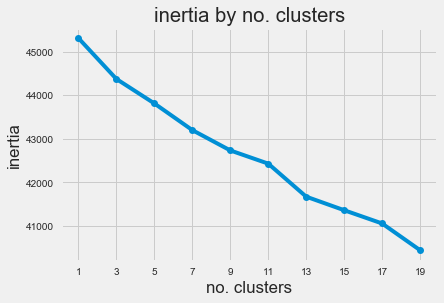

In [267]:
find_optimal_clusters(regular_hr_tfidf_X, min_k=1, max_k=20, delta_k=2)

Fit 1 clusters
Fit 3 clusters
Fit 5 clusters
Fit 7 clusters
Fit 9 clusters
Fit 11 clusters
Fit 13 clusters
Fit 15 clusters
Fit 17 clusters
Fit 19 clusters


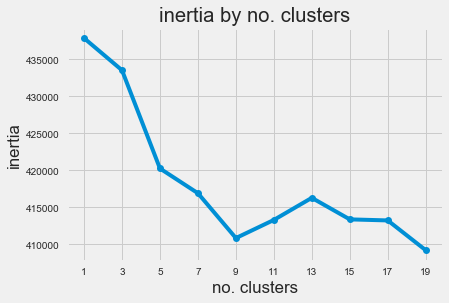

In [266]:
find_optimal_clusters(regular_hr_cv_doc_word, min_k=1, max_k=20, delta_k=2)

Fit 1 clusters
Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


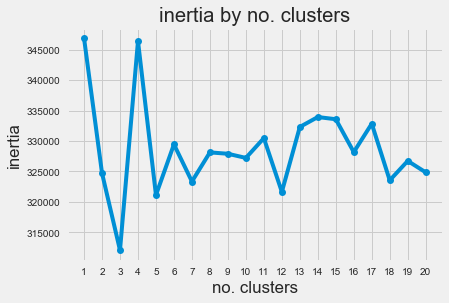

In [275]:
find_optimal_clusters(regular_lr_cv_doc_word, min_k=1, max_k=20, delta_k=1);

Fit 1 clusters
Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


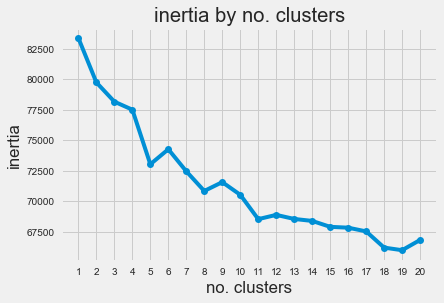

In [269]:
find_optimal_clusters(vine_lr_cv_doc_word, min_k=1, max_k=20, delta_k=1);

Fit 1 clusters
Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


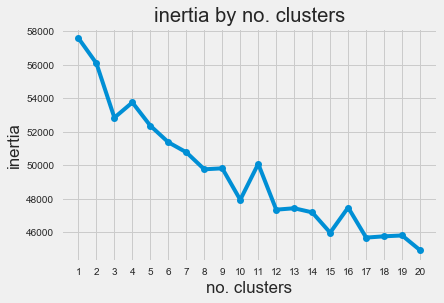

In [274]:
find_optimal_clusters(vine_hr_cv_doc_word, min_k=1, max_k=20, delta_k=1);

Silhouette Coefficient: 0.069
Cluster 0:
 gift
 loved
 friend
 christmas
 purchased
 daughter
 son
 year
 husband
 someone
 old
 given
Cluster 1:
 reference
 quick
 guide
 need
 library
 used
 time
 new
 work
 recommend
 keep
 go
Cluster 2:
 series
 next
 character
 loved
 first
 recommend
 enjoyed
 whole
 put
 fan
 another
 new
Cluster 3:
 loved
 daughter
 year
 old
 put
 son
 recommend
 friend
 year old
 kid
 child
 first
Cluster 4:
 recommend
 life
 year
 new
 work
 condition
 want
 put
 enjoyed
 need
 fun
 first
Cluster 5:
 time
 life
 first
 year
 arrived
 recommend
 new
 character
 day
 take
 back
 work



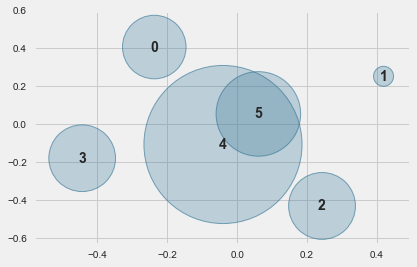

In [278]:
cluster_plots(6, regular_hr_tfidf_doc_word, regular_hr_tfidf, cat=True)

Silhouette Coefficient: 0.031
Cluster 0:
 new
 used
 recommend
 gift
 condition
 recipe
 class
 looking
 need
 work
 find
 still
Cluster 1:
 love
 series
 old
 year
 daughter
 kid
 son
 gift
 still
 year old
 want
 picture
Cluster 2:
 first
 character
 life
 series
 year
 inch
 old
 novel
 think
 end
 year old
 work



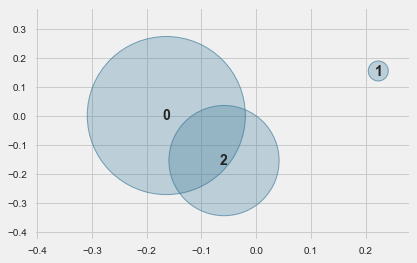

In [287]:
cluster_plots(3, regular_lr_tfidf_doc_word, regular_lr_tfidf, cat=True)

Silhouette Coefficient: 0.405
Cluster 0:
 letter
 might
 job
 dummies
 seen
 style
 digital
 business
 review
 across
 non
 person
Cluster 1:
 war
 conflict
 given
 american
 fresh
 subject
 detail
 experience
 campaign
 fact
 fight
 sort
Cluster 2:
 woman
 war
 father
 girl
 say
 might
 learn
 guide
 next
 home
 point
 others
Cluster 3:
 idea
 american
 americans
 left
 week
 job
 president
 hour
 worker
 nothing
 class
 america



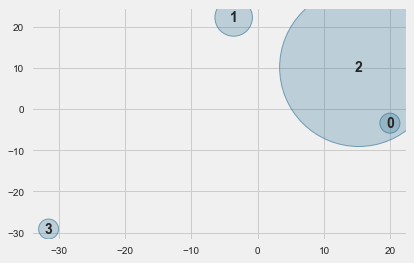

In [183]:
cluster_plots(4, vine_hr_cv_doc_word, vine_hr_cv, cat=True)

Silhouette Coefficient: 0.225
Cluster 0:
 chapter
 mother
 mystery
 man
 school
 action
 relationship
 father
 others
 girl
 person
 seemed
Cluster 1:
 data
 big
 chapter
 based
 technology
 asin
 phrase
 short
 web
 ask
 site
 almost
Cluster 2:
 mr
 please
 animal
 children
 appears
 response
 illustration
 saying
 complete
 particularly
 unfortunately
 asks
Cluster 3:
 henry
 york
 king
 english
 england
 war
 marriage
 death
 wife
 ms
 brother
 killed
Cluster 4:
 car
 original
 entertaining
 detail
 become
 background
 went
 considered
 doe job
 title
 involved
 enemy



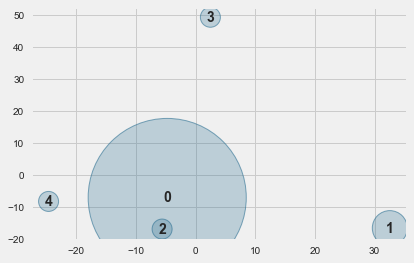

In [181]:
cluster_plots(5, vine_lr_cv_doc_word, vine_lr_cv, cat=True)

## Topic Modeling

In [193]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### NMF

In [230]:
def nmf_test(X, vec, dim):
    
    nmf = NMF(dim, random_state=15)
    nmf_topic = nmf.fit_transform(X)
    nmf_word = pd.DataFrame(nmf.components_.round(2),
                           index=np.arange(1,dim+1),
                           columns=vec.get_feature_names())
    topics = nmf_word.transpose()
    for i, categories in enumerate(topics.columns):
        keywords = topics.loc[:,categories].sort_values(ascending=False).head(5)
        print(f'Topic {i}: {keywords.index.values}\n')
        
    return nmf, nmf_topic

In [279]:
nmf_regular_hr, topics_regular_hr = nmf_test(regular_hr_tfidf_doc_word, regular_hr_tfidf, 6)
len(topics_regular_hr)

Topic 0: ['time' 'life' 'work' 'new' 'first']

Topic 1: ['loved' 'gift' 'daughter' 'friend' 'son']

Topic 2: ['series' 'next' 'character' 'enjoyed' 'first']

Topic 3: ['year' 'old' 'year old' 'daughter' 'son']

Topic 4: ['condition' 'arrived' 'price' 'new' 'described']

Topic 5: ['recommend' 'definitely' 'everyone' 'enjoyed' 'product']



53993

In [284]:
nmf_regular_lr, topics_regular_lr = nmf_test(regular_lr_tfidf_doc_word, regular_lr_tfidf, 3)
len(topics_regular_lr)

Topic 0: ['first' 'inch' 'character' 'work' 'new']

Topic 1: ['love' 'old' 'year' 'year old' 'series']

Topic 2: ['gift' 'condition' 'arrived' 'friend' 'used']



20481

In [207]:
nmf_vine_lr, topics_vine_lr = nmf_test(vine_lr_cv_doc_word, vine_lr_cv, 5)
len(topics_vine_lr)

Topic 0: ['slave' 'person' 'away' 'chapter' 'man']

Topic 1: ['data' 'big' 'chapter' 'based' 'technology']

Topic 2: ['henry' 'york' 'king' 'english' 'england']

Topic 3: ['theory' 'general' 'observation' 'evidence' 'considered']

Topic 4: ['volume' 'edition' 'critical' 'version' 'inchthe']



895

In [238]:
nmf_vine_hr, topics_vine_hr = nmf_test(vine_hr_cv_doc_word, vine_hr_cv, 4)
len(topics_vine_hr)

Topic 0: ['idea' 'american' 'americans' 'left' 'week']

Topic 1: ['say' 'might' 'learn' 'detail' 'asin']

Topic 2: ['war' 'conflict' 'fresh' 'world war' 'fight']

Topic 3: ['race' 'train' 'elizabeth' 'trip' 'problem']



598

In [1259]:
nmf_topic

array([[2.89194470e-02, 1.06267879e-03, 2.37306279e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.68703764e-03, 6.52002077e-06, 0.00000000e+00, ...,
        0.00000000e+00, 8.93979324e-02, 1.99187788e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.67161329e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.79494043e-03, 1.93249759e-05],
       [0.00000000e+00, 1.68528699e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [241]:
topic_map_vine_hr = {
    0: 'American Values',
    1: 'Educational',
    2: 'War History',
    3: 'Race/Social Issues'
}

In [242]:
topic_map_regular_hr = {
    0: 'Self-help',
    1: 'Family: Gift',
    2: 'Fiction: Series',
    3: 'Family: Age',
    4: 'Delivery condition',
    5: 'Recommended'
}

In [243]:
topic_map_vine_lr = {
    0: 'Race',
    1: 'Technology',
    2: 'English Monarchy',
    3: 'Theoretical',
    4: 'Series edition'
}

In [244]:
topic_map_regular_lr = {
    0: 'Errors',
    1: 'Family: Gift',
    2: 'Fiction: Series',
    3: 'Family: Age',
    4: 'Delivery condition',
    5: 'Recommended'
}

In [245]:
vine_users_hr_corpus['NMF_topic'] = topics_vine_hr.argmax(axis=1)
vine_users_hr_corpus['NMF_topic_name'] = vine_users_hr_corpus.NMF_topic.map(topic_map_vine_hr)

In [246]:
regular_users_hr_corpus['NMF_topic'] = topics_regular_hr.argmax(axis=1)
regular_users_hr_corpus['NMF_topic_name'] = regular_users_hr_corpus.NMF_topic.map(topic_map_regular_hr)

In [247]:
vine_users_lr_corpus['NMF_topic'] = topics_vine_lr.argmax(axis=1)
vine_users_lr_corpus['NMF_topic_name'] = vine_users_lr_corpus.NMF_topic.map(topic_map_vine_lr)


In [288]:
regular_users_lr_corpus['NMF_topic'] = topics_regular_lr.argmax(axis=1)
regular_users_lr_corpus['NMF_topic_name'] = regular_users_lr_corpus.NMF_topic.map(topic_map_regular_lr)


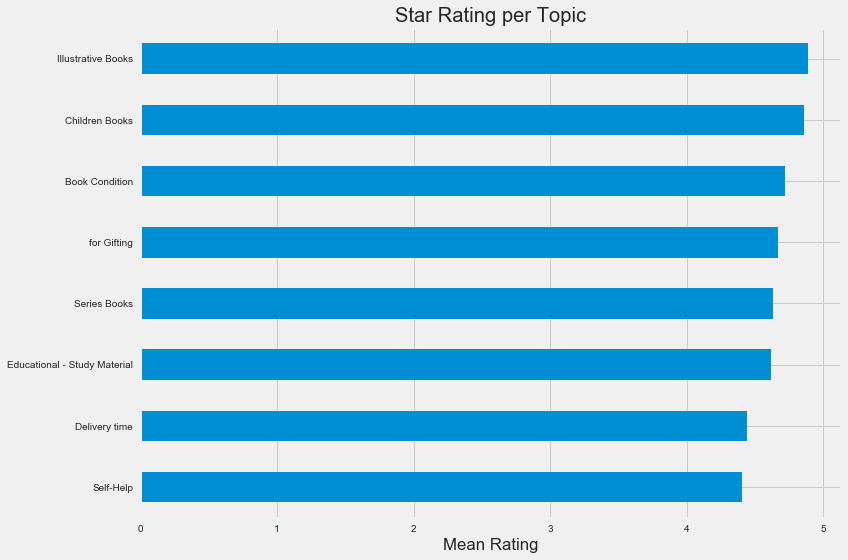

In [1274]:
plt.figure(figsize=(12, 8))
topic_stars_grouped = regular_users_corpus.groupby('NMF_topic_name').star_rating.mean().sort_values()
# corpus.groupby('topic_name').claps.mean().sort_values().plot(kind='barh')
topic_stars_grouped.plot(kind='barh')
plt.xlabel('Mean Rating')
plt.ylabel('')
plt.title('Star Rating per Topic')
plt.tight_layout()
# plt.savefig('median_claps_topic.svg');

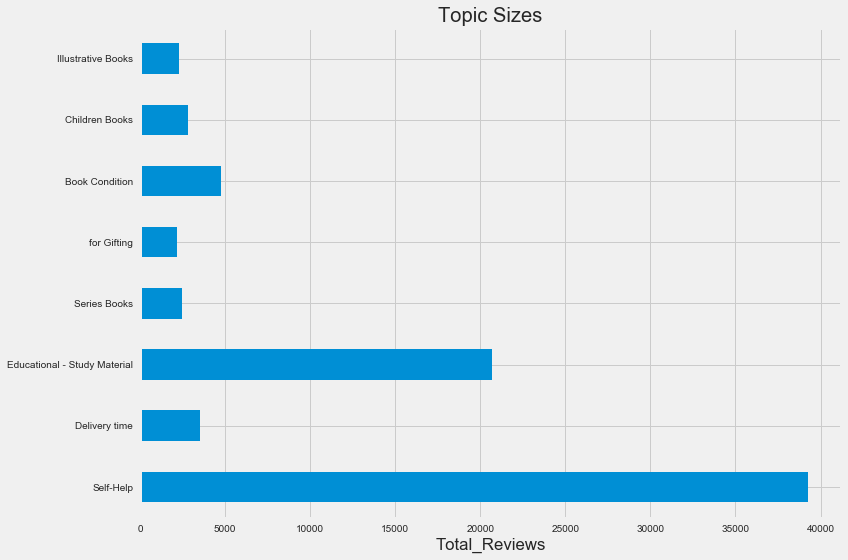

In [1275]:
plt.figure(figsize=(12, 8))
regular_users_corpus.groupby('NMF_topic_name').topic.count()[topic_stars_grouped.index].plot(kind='barh')
plt.xlabel('Total_Reviews')
plt.ylabel('')
plt.title('Topic Sizes')
plt.tight_layout()
# plt.savefig('topic_sizes.svg');

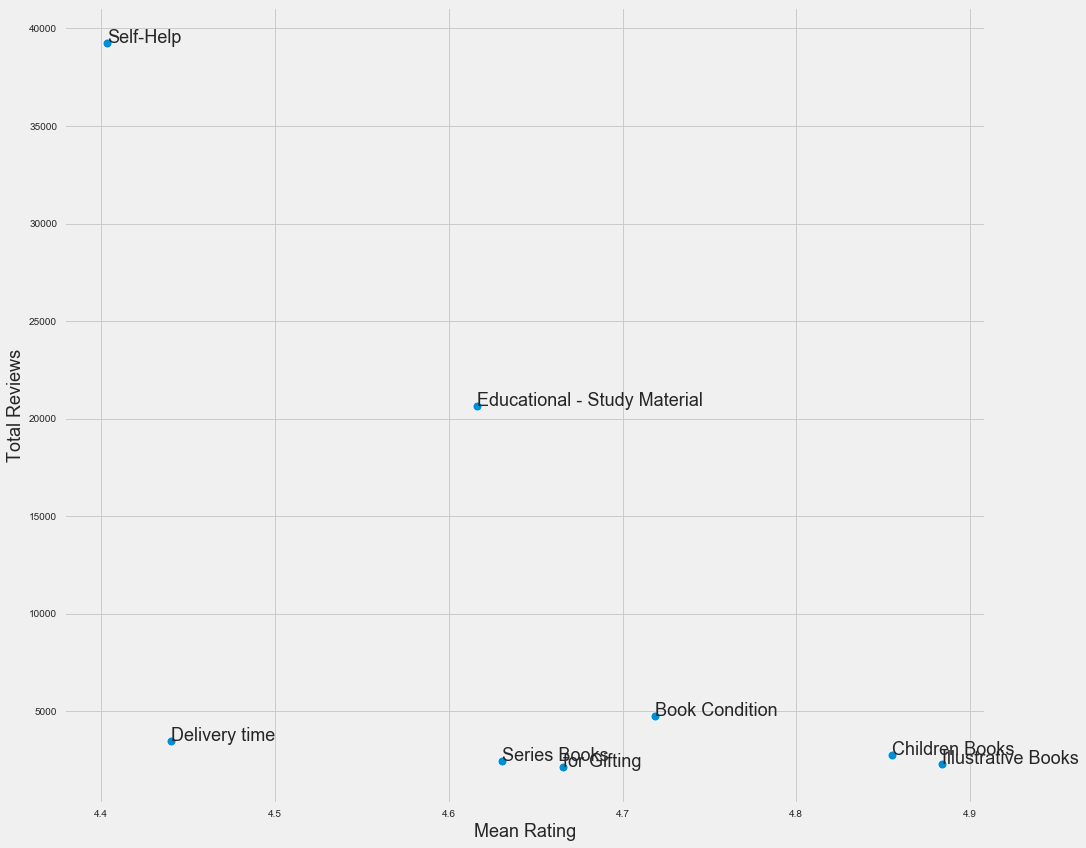

In [1290]:
plt.figure(figsize=(14,12))
data = regular_users_corpus.groupby('NMF_topic_name').agg({'star_rating':'mean', 'NMF_topic':'count'}).sort_index()
data['name'] = data.index
sns.scatterplot(x='star_rating', y='NMF_topic', data=data, s=80)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), size=18)

label_point(data.star_rating, data.NMF_topic, data.name, plt.gca())

plt.xlabel('Mean Rating', size=18)
plt.ylabel('Total Reviews', size=18)
plt.tight_layout()
# plt.savefig('article_clap_scatter.svg');




## Visualization

In [1263]:
nmf_sc = StandardScaler().fit_transform(topics_8)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=5)
nmf_pca = pca.fit_transform(nmf_sc)

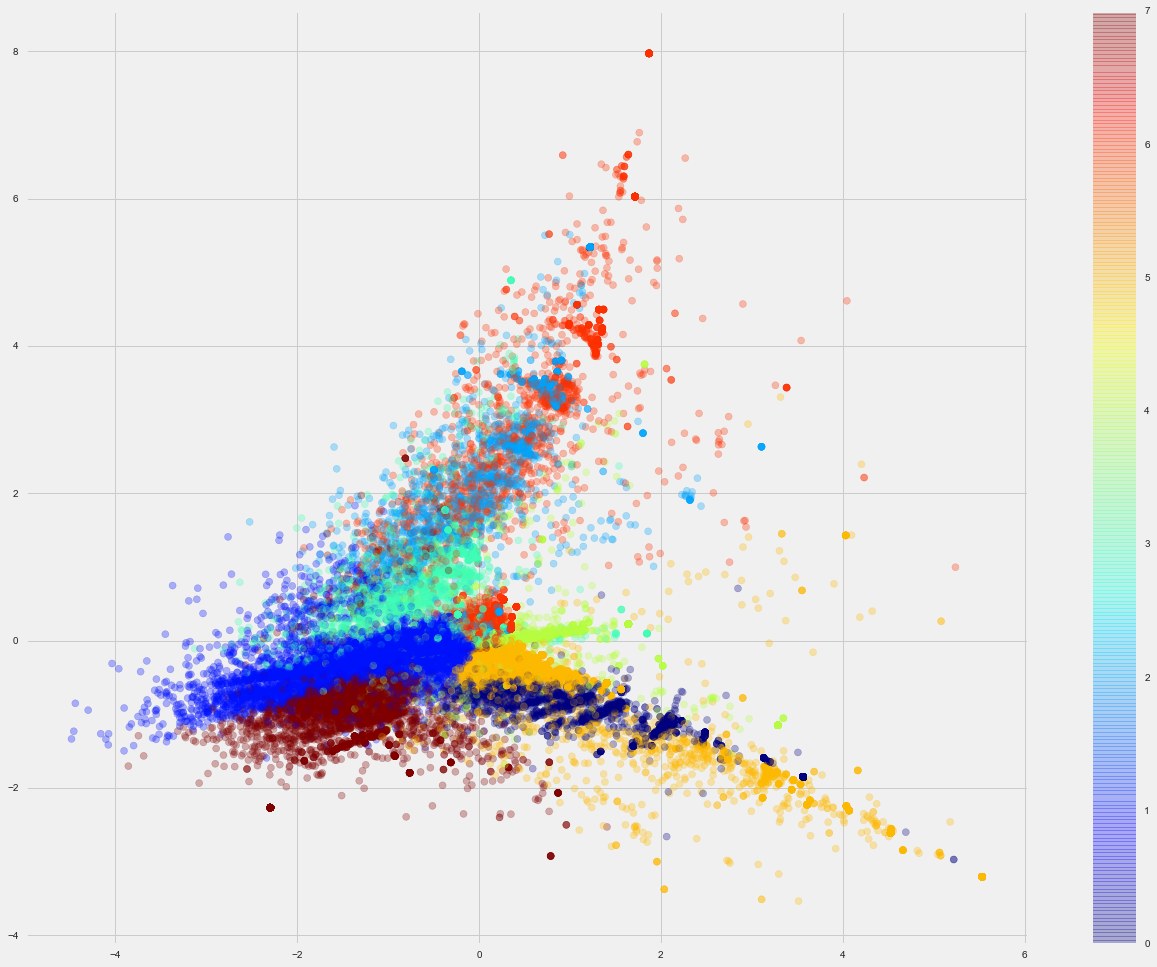

In [1264]:
plt.figure(figsize=(20,16))
plt.scatter(nmf_pca[:,0], nmf_pca[:,1], c=nmf_sc.argmax(axis=1), cmap='jet', alpha=0.3)
plt.colorbar();

In [1291]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, verbose=0)
data = model.fit_transform(nmf_sc)

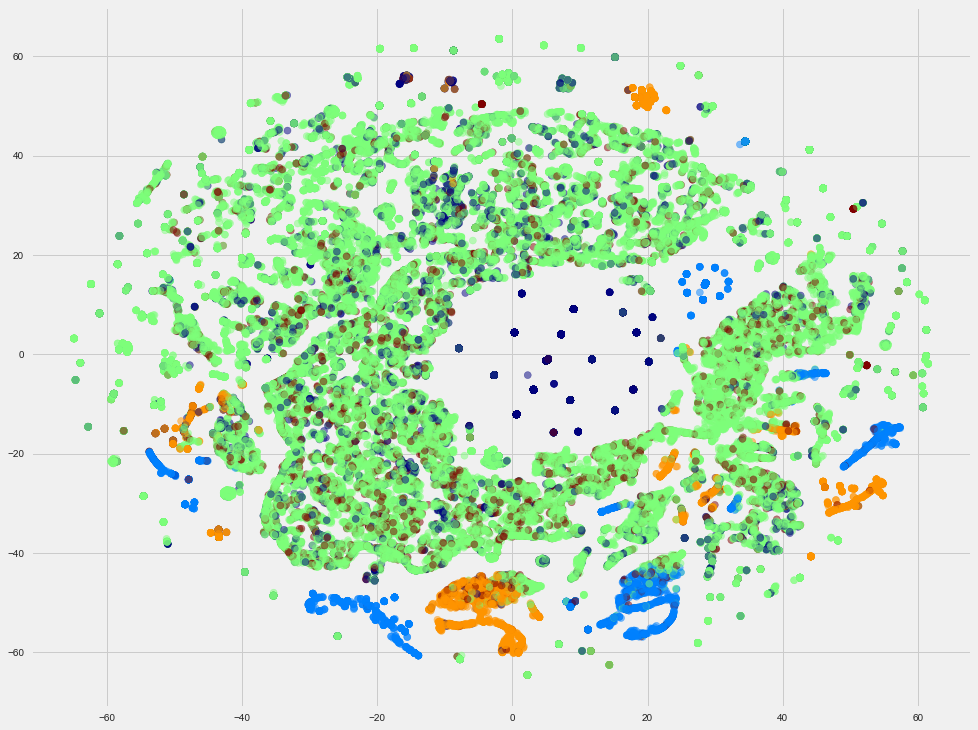

In [1293]:
plt.figure(figsize=(15,12))
plt.scatter(data[:,0], data[:,1], c=regular_users_corpus.topic,cmap='jet', alpha=.5);

## LDA

In [1337]:
from gensim import corpora, models, similarities, matutils


In [1338]:
doc_word_cv = cv.transform(regular_users_corpus.review_body).transpose()
doc_word_tfidf = tfidf.transform(regular_users_corpus.review_body).transpose()

In [1339]:
corpus_cv = matutils.Sparse2Corpus(doc_word_cv)
corpus_tfidf = matutils.Sparse2Corpus(doc_word_tfidf)

In [1340]:
id2word_cv = dict((v, k) for k, v in cv.vocabulary_.items())
id2word_tfidf = dict((v, k) for k, v in tfidf.vocabulary_.items())

In [1341]:
len(id2word_cv)

188

In [1342]:
lda_cv = models.LdaModel(corpus=corpus_cv, num_topics=8, id2word=id2word, passes=5, random_state=5)
lda_tfidf = models.LdaModel(corpus=corpus_tfidf, num_topics=8, id2word=id2word, passes=5, random_state=5)

In [1343]:
lda_cv.print_topics()

[(0,
  '0.154*"purchased" + 0.081*"kind" + 0.066*"color" + 0.052*"learn" + 0.052*"wanted" + 0.051*"hope" + 0.048*"example" + 0.042*"arrived" + 0.040*"kid" + 0.037*"chapter"'),
 (1,
  '0.041*"study" + 0.037*"might" + 0.032*"kind" + 0.029*"two" + 0.027*"understand" + 0.025*"may" + 0.022*"enough" + 0.020*"making" + 0.017*"gift" + 0.017*"start"'),
 (2,
  '0.135*"done" + 0.121*"friend" + 0.066*"especially" + 0.062*"point" + 0.060*"first" + 0.058*"forward" + 0.052*"fun" + 0.049*"condition" + 0.040*"said" + 0.040*"making"'),
 (3,
  '0.090*"review" + 0.076*"far" + 0.062*"useful" + 0.049*"mind" + 0.041*"much" + 0.040*"another" + 0.038*"change" + 0.036*"text" + 0.034*"last" + 0.033*"interested"'),
 (4,
  '0.071*"beautiful" + 0.066*"thank" + 0.056*"someone" + 0.055*"pretty" + 0.048*"time" + 0.046*"question" + 0.045*"put" + 0.045*"came" + 0.043*"child" + 0.042*"back"'),
 (5,
  '0.062*"simple" + 0.050*"thanks" + 0.043*"enough" + 0.042*"still" + 0.040*"life" + 0.038*"big" + 0.033*"recommend" + 0.032

In [1344]:
lda_tfidf.print_topics()

[(0,
  '0.156*"color" + 0.115*"hope" + 0.104*"purchased" + 0.063*"experience" + 0.060*"learn" + 0.058*"ever" + 0.057*"every" + 0.053*"kid" + 0.045*"made" + 0.043*"idea"'),
 (1,
  '0.025*"two" + 0.022*"understand" + 0.021*"thank" + 0.020*"product" + 0.020*"day" + 0.020*"might" + 0.018*"kind" + 0.018*"still" + 0.016*"probably" + 0.016*"even"'),
 (2,
  '0.126*"friend" + 0.096*"done" + 0.077*"got" + 0.076*"making" + 0.065*"especially" + 0.061*"condition" + 0.056*"set" + 0.046*"kind" + 0.041*"forward" + 0.038*"first"'),
 (3,
  '0.080*"review" + 0.039*"another" + 0.038*"useful" + 0.035*"interested" + 0.032*"mind" + 0.031*"described" + 0.031*"last" + 0.024*"man" + 0.022*"going" + 0.021*"fantastic"'),
 (4,
  '0.074*"study" + 0.051*"pretty" + 0.050*"time" + 0.050*"question" + 0.046*"beautiful" + 0.041*"put" + 0.040*"someone" + 0.036*"fact" + 0.036*"reader" + 0.034*"find"'),
 (5,
  '0.069*"others" + 0.066*"arrived" + 0.063*"character" + 0.061*"use" + 0.055*"course" + 0.049*"keep" + 0.044*"order"

In [1301]:
lda_corpus = lda[corpus_]
lda_corpus

In [1302]:
lda_docs = [doc for doc in lda_corpus]

In [1303]:
lda_docs[0:5]

[[(0, 0.012514846),
  (1, 0.6895039),
  (2, 0.1480974),
  (3, 0.012531008),
  (4, 0.012516787),
  (5, 0.09979253),
  (6, 0.012537602),
  (7, 0.012505927)],
 [(0, 0.125),
  (1, 0.125),
  (2, 0.125),
  (3, 0.125),
  (4, 0.125),
  (5, 0.125),
  (6, 0.125),
  (7, 0.125)],
 [(0, 0.062500186),
  (1, 0.06250995),
  (2, 0.062500186),
  (3, 0.062500186),
  (4, 0.06250019),
  (5, 0.5624889),
  (6, 0.062500186),
  (7, 0.062500186)],
 [(0, 0.093124904),
  (1, 0.5028393),
  (3, 0.039110832),
  (4, 0.30866876),
  (6, 0.04453095)],
 [(0, 0.0104217855),
  (1, 0.14617166),
  (2, 0.0104168495),
  (3, 0.010418745),
  (4, 0.3971711),
  (5, 0.4045661),
  (6, 0.0104168495),
  (7, 0.0104168495)]]

In [1304]:
topic_map = {
    0: 'Educational - Study Material',
    1: 'Self-Help / Recommended',
    2: 'Children Books',
    3: 'Series Books',
    4: 'Illustrative Books',
    5: 'Book Condition',
    6: 'for Gifting',
    7: 'Delivery time'
}

In [ ]:
regular_users_corpus['LDA_topic'] = lda_docs.argmax(axis=1)
regular_users_corpus['LDA_topic_name'] = regular_users_corpus.topic.map(topic_map)